# Objetivo
Observar la relación entre las palabras y el cambio en el valor del Bitcoin al igual que probar diferentes modelos hasta obtener el que se adapte mejor.

In [118]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import re, string
import spacy

plt.rcParams['figure.figsize'] = [10, 6]

## Se obtienen los datos ya clasificados

In [119]:
data = pd.read_csv('../data_files/Datos.csv')
data = data.drop(['i'],axis=1)
# Se aleatoriza la muestra
data = data.sample(frac=1, random_state=0).reset_index(drop=True)
data.head()

,Texto,class
0,William Suberg\n24 Apr 2022\nBitcoin establece...,0
1,17 Jun 2022\nRusia parece estar preparándose p...,1
2,03 May 2022\nBitpanda lanza nuevos ETNs de Eth...,0
3,Yashu Gola\n06 Jul 2022\nLas acciones mineras ...,1
4,01 Jul 2022\nLa pesadilla de junio adquiere un...,0


## Se pre-procesan los datos
En está sección se eliminan las stop_words y todo tipo de caracteres especiales, al igual que es normaliza y lematiza el texto

In [120]:
# Normalización del texto

nlp = spacy.load("es_core_news_sm")
stopwords = spacy.lang.es.stop_words.STOP_WORDS
def alfabetiza(text):
    doc = nlp(text, disable=['ner', 'parser'])
    lemmas = [token.lemma_ for token in doc]

    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)

def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [121]:
# Se aplican los cambios
data['Texto'] = data['Texto'].apply(wordopt)
data['Texto'] = data['Texto'].apply(alfabetiza)
data.head()

,Texto,class
0,william suberg apr bitcoin establecer cierre s...,0
1,jun rusia parecer minar bitcoin quema gas giga...,1
2,may bitpanda lanza etns ethereum solán cardano...,0
3,yashu gola jul acción minero bitcoin recuperar...,1
4,jul pesadilla junio adquirir significado mes b...,0


## Exploración
Es complicado visualizar textos tan grandes, por lo que sólo se obtendrán algunas entradas representativas de cada clase.

In [122]:
# Se crea una nueva columna con las palabras más frecuentes
def frecuencia(texto):
    texto = nlp(texto)    
    words = [token.text
            for token in texto
            if not token.is_stop and not token.is_punct]
    word_freq = Counter(words)
    
    return word_freq.most_common(5)
data['frecuencia'] = data['Texto'].apply(frecuencia)

Para visualizar, se hace uso de una nube de palabras

In [162]:
df1 = data[data['class']==1]
df0 = data[data['class']==0]
df1 = df1.reset_index()
words_1 = ''
for index, row in df1.iterrows():
    for val in row['frecuencia']:
        words_1 += val[0] + ' '
df1 = df1.reset_index()
words_0 = ''
for index, row in df0.iterrows():
    for val in row['frecuencia']:
        words_0 += val[0] + ' '

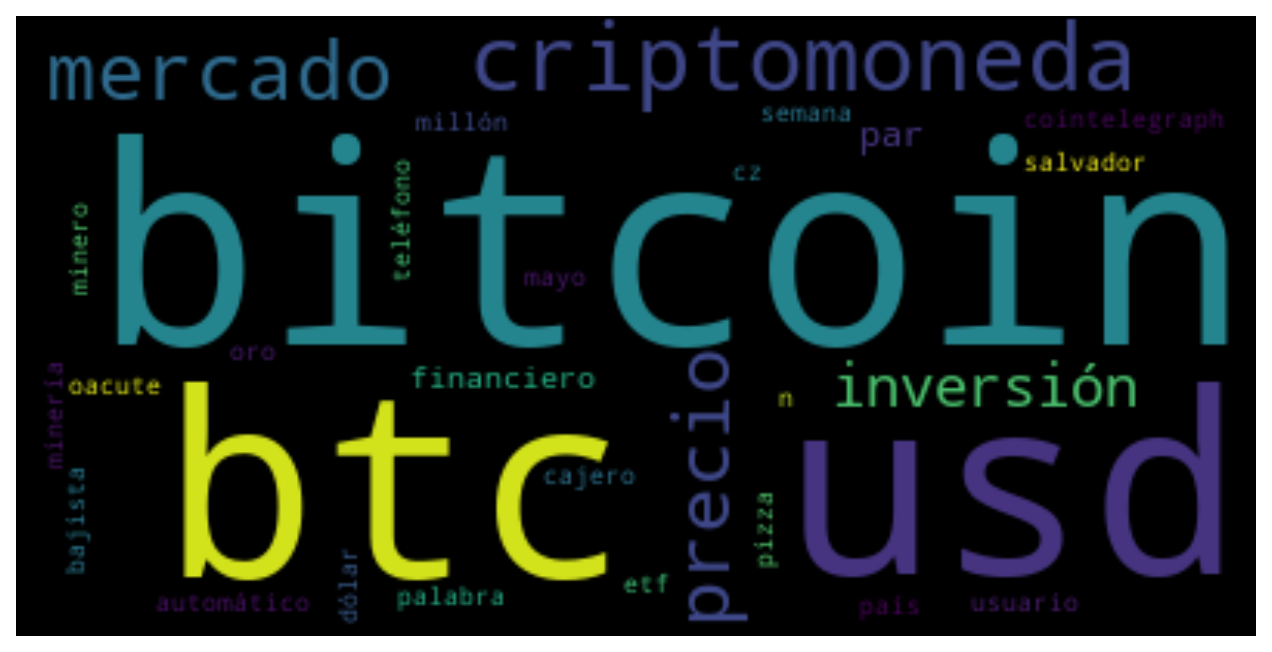

In [124]:
word_cloud = WordCloud().generate(words_1)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

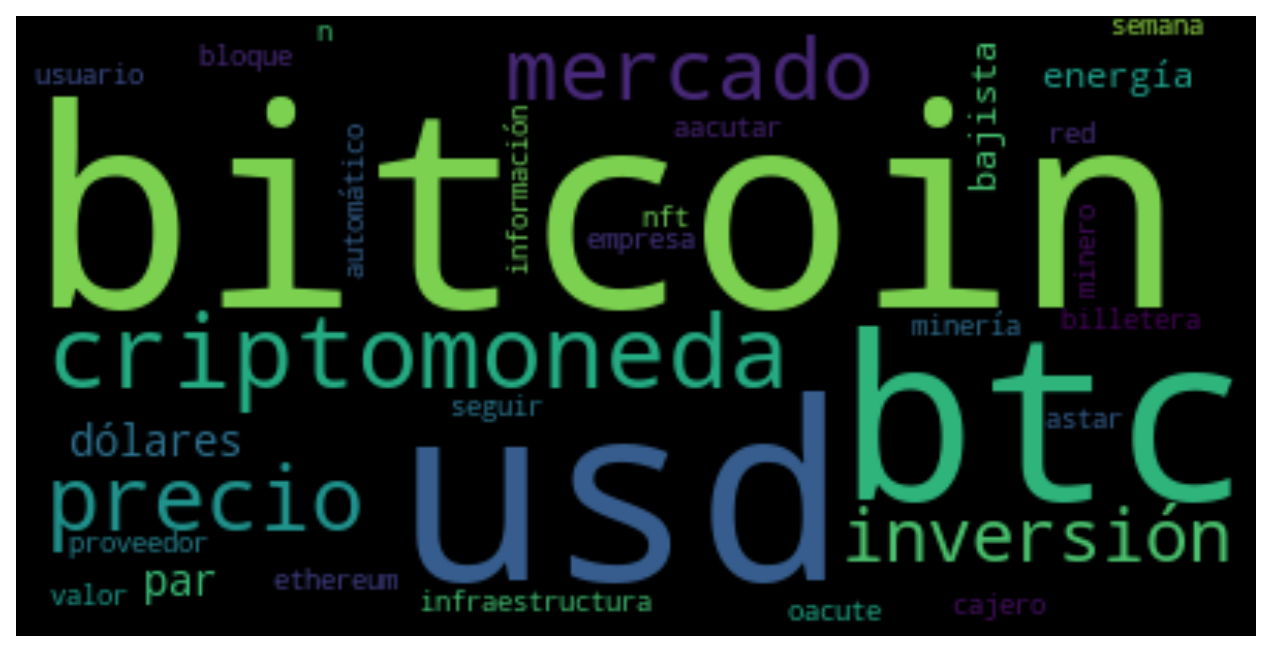

In [125]:
word_cloud = WordCloud().generate(words_0)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Notemos que las diferencias entre cada clase son pocas, por ejemplo, en la clase uno el sustantivo NFT no aparece; esto me hace pensar que las diferencias entre cada clase se dirigen a las palabras menos comúnes.

In [126]:
# Creación de datos de prueba y entrenamiento
from sklearn.model_selection import train_test_split

x = data["Texto"]
y = data["class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [127]:
# Conversión de texto a vectores
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

# Implementación de modelos

In [128]:
from sklearn.metrics import classification_report

## Modelo 1
### Potenciación del gradiente

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state = 0, n_estimators=500, loss='log_loss',max_depth=3,learning_rate=0.05,min_weight_fraction_leaf=0.5)
GBC.fit(xv_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, min_weight_fraction_leaf=0.5,
                           n_estimators=500, random_state=0)

In [130]:
pred_gbc = GBC.predict(xv_test)
GBC.score(xv_test, y_test)

0.6296296296296297

In [131]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.65      0.81      0.72        16
           1       0.57      0.36      0.44        11

    accuracy                           0.63        27
   macro avg       0.61      0.59      0.58        27
weighted avg       0.62      0.63      0.61        27



## Modelo 2

In [132]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0,penalty = 'l2')
LR.fit(xv_train, y_train)

LogisticRegression(random_state=0)

In [133]:
pred_lr = LR.predict(xv_test)
LR.score(xv_test, y_test)

0.5925925925925926

In [134]:
print(classification_report(y_test, pred_lr,zero_division=1))

              precision    recall  f1-score   support

           0       0.60      0.94      0.73        16
           1       0.50      0.09      0.15        11

    accuracy                           0.59        27
   macro avg       0.55      0.51      0.44        27
weighted avg       0.56      0.59      0.50        27



## Modelo 3

In [135]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(criterion='entropy',min_weight_fraction_leaf=0.5)
DTC.fit(xv_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_weight_fraction_leaf=0.5)

In [136]:
pred_dtc = DTC.predict(xv_test)
DTC.score(xv_test, y_test)

0.5925925925925926

In [137]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.65      0.69      0.67        16
           1       0.50      0.45      0.48        11

    accuracy                           0.59        27
   macro avg       0.57      0.57      0.57        27
weighted avg       0.59      0.59      0.59        27



## Modelo 4

In [138]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=500,criterion='entropy',min_weight_fraction_leaf=0.5,min_samples_leaf=2)
RFC.fit(xv_train,y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_weight_fraction_leaf=0.5, n_estimators=500)

In [139]:
pred_rfc= RFC.predict(xv_test)
RFC.score(xv_test,y_test)

0.5925925925925926

In [140]:
print(classification_report(y_test, pred_rfc,zero_division=1))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        16
           1       1.00      0.00      0.00        11

    accuracy                           0.59        27
   macro avg       0.80      0.50      0.37        27
weighted avg       0.76      0.59      0.44        27



# Se exporta el mejor modelo

In [165]:
from joblib import dump
dump(GBC,'../modelos/GBClassifier.joblib')

['../modelos/GBClassifier.joblib']